In [182]:
from scipy import sparse
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import tensorflow as tf
import re
from sklearn.metrics import confusion_matrix

In [183]:
benign = pd.read_csv('./url_0.csv').sample(n = 44999, random_state = 2019)
phishing = pd.read_csv('./url_1.csv') 

In [184]:
benign = pd.DataFrame(benign)
benign = pd.DataFrame({'url' : benign['http://www.liquidgeneration.com/'], 'cat' : benign.Adult})
benign = benign.append(pd.Series(['http://www.liquidgeneration.com/','Adult'],index=benign.columns),ignore_index=True)
phishing = pd.DataFrame(phishing)

In [185]:
benign.shape, phishing.shape

((45000, 2), (15261, 8))

In [186]:
benign = benign.drop(columns = ['cat'])
phishing = phishing.drop(columns = ['phish_id','submission_time','verified','phish_detail_url',
                                  'verification_time','online','target'])

In [187]:
benign['label'] = 0
phishing['label'] = 1

In [188]:
df = pd.concat([benign,phishing]).reset_index(drop = 'True')

# Feature Eng'ring
 - Digit Count of URL
 - URL 길이
 - Checking URL is Typosquatted or not (google.com --> goggle.com)
 - Subdomain 개수
 - Top level Domain 이 자주 쓰이는 Domain인가?
 - 등록후 지난 일수
 - http:// or https://
 - #of http:// or https://
 - 특수문자(#, =, /,&)
 - com 개수

In [189]:
 df['length'] = df.url.str.len()

In [190]:
df['sharp'] = (df.url.str.count('#'))
df['equal'] = (df.url.str.count('='))
df['slash'] = ((df.url.str.count('/')) - 2)
df['dbleslash'] = (df.url.str.count('//')) - 1
df['question'] = (df.url.str.count('\?'))
df['com'] = (df.url.str.count('.com'))
df['dot'] = (df.url.str.count('\.'))
df['protocols'] = (df.url.str.count('https://') + df.url.str.count('http://'))
df['comma'] = (df.url.str.count('\,'))

In [191]:
gb  = df.groupby(by = df.label).mean()

In [192]:
gb

,label,length,sharp,equal,slash,dbleslash,question,com,dot,protocols,comma
label,,,,,,,,,,,
0,0.0,35.809978,0.000978,0.052956,1.474444,0.000689,0.034044,0.678333,2.337178,0.999622,0.000000
1,1.0,75.852041,0.008322,0.535548,3.084726,0.016185,0.244283,0.750999,2.545049,1.011336,0.008977


# Feature Importance

In [193]:
model = XGBClassifier()
model.fit(df.drop(columns = ['url','label']), df.label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [194]:
df.columns

Index(['url', 'label', 'length', 'sharp', 'equal', 'slash', 'dbleslash',
       'question', 'com', 'dot', 'protocols', 'comma'],
      dtype='object')

[0.4348016  0.02832716 0.03409005 0.07396687 0.04464323 0.02885386
 0.08180476 0.23030968 0.02994067 0.01326214]


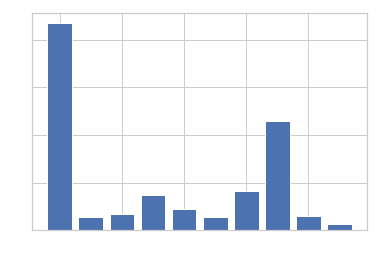

In [195]:
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

# Top Level Domain / Sub Domain 

In [196]:
tld = df.url.str.rpartition('.')[2]
tld = tld.str.replace('\/','')
subdomain = df.url.str.rpartition('.')[0]
subdomain = subdomain.str.rpartition('.')[2].str.replace('http://','').replace('https://','')

# 문자열 전처리

In [197]:
df = df.dropna()

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [199]:
words = df.url.str.split(r'[/|.]').apply(lambda x : " ".join(x))

In [200]:
vectorizer = TfidfVectorizer(lowercase = 'False', max_features = 10000, 
                             token_pattern = '(([\w!@#$%^&*\(\)_\+\-\={}\|[\]:";\'<>?,./])+)' )
X = vectorizer.fit(words)
feat = X.get_feature_names()
X = vectorizer.transform(words)
X.shape, df.drop(columns = ['url','label']).shape

((60261, 10000), (60261, 10))

In [201]:
a = '!@#$%^||||+_)AACVBscfsf'
b = re.match('(([\w!@#$%^&*\(\)_\+\-\={}\|[\]:";\'<>?,./])+)', a)
print(b)

<re.Match object; span=(0, 23), match='!@#$%^||||+_)AACVBscfsf'>


In [202]:
X_train = sparse.hstack([df.drop(columns = ['url','label']), X]).tocsr()
y_train = df.label

In [203]:
import tensorflow as tf

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2019)

In [205]:
X_train.shape[1:]

(10010,)

In [206]:
1,2,5,7,10,11,13,14,22,26,35,55,65,70,77,91,110,130,143,154,182,286,385,455,715,770,910,1001,1430,2002,5005,10010

(1,
 2,
 5,
 7,
 10,
 11,
 13,
 14,
 22,
 26,
 35,
 55,
 65,
 70,
 77,
 91,
 110,
 130,
 143,
 154,
 182,
 286,
 385,
 455,
 715,
 770,
 910,
 1001,
 1430,
 2002,
 5005,
 10010)

In [208]:
c_input = tf.keras.Input(shape=(X_train.shape[1:]))
H = tf.keras.layers.Reshape((110, int(X_train.shape[1]/110), 1))(c_input)
#H = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=20, kernel_size=(2), padding='same', activation='tanh'))(H)
#H = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2))(H)
#H = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=20, kernel_size=(2), padding='same', activation='tanh'))(H)
#H = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2))(H)
H = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=20, kernel_size=(2), padding='same', activation='tanh'))(H)
H = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2))(H)
H = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(H)
H = tf.keras.layers.Dropout(0.5)(H)
#H CuDNNGRU(256, recurrent_dropout=0.5, unroll=True, return_sequences=True)(H)
#H = GRU(256, recurrent_dropout=0.5, unroll=True, return_sequences=False, go_backwards=True)(H)
H = tf.keras.layers.GRU(128, return_sequences=True)(H)
H = tf.keras.layers.GRU(128, return_sequences=False, go_backwards=True)(H)
H = tf.keras.layers.Dropout(rate=0.5)(H)
H = tf.keras.layers.Dense(32, activation='tanh')(H)
c_output = tf.keras.layers.Dense(2, activation='softmax')(H)
model_cnn_lstm = tf.keras.Model(c_input, c_output)
model_cnn_lstm.summary()
# model_cnn_lstm = multi_gpu_model(model_cnn_lstm, gpus=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 10010)             0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 110, 91, 1)        0         
_________________________________________________________________
time_distributed_60 (TimeDis (None, 110, 91, 20)       60        
_________________________________________________________________
time_distributed_61 (TimeDis (None, 110, 45, 20)       0         
_________________________________________________________________
time_distributed_62 (TimeDis (None, 110, 900)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 110, 900)          0         
_________________________________________________________________
gru_25 (GRU)                 (None, 110, 128)          395136    
__________

In [209]:
def plot_history(model_input, mode='loss', val_mode=True, title='Entropy'):
    history = model_input.history
    if(val_mode):
        plt.plot(history.history[mode])
        plt.plot(history.history['val_'+mode])
        plt.title(title)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history[mode])
        plt.title(title)
        plt.legend(['train'], loc='upper right')
        plt.show()

In [ ]:
def wrapped_confusion_matrix(modelInput, feature, label, class_list=["first", "second"], normalize=False, fig_size=(5,5)):
    pred = modelInput.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    np.set_printoptions(precision=2)
    plt.figure(figsize=fig_size) 
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(class_list)), class_list, rotation=45)
    plt.yticks(np.arange(len(class_list)), class_list)
    if(normalize):
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def plot_history(model_input, mode='loss', val_mode=True, title='Entropy'):
    history = model_input.history
    if(val_mode):
        plt.plot(history.history[mode])
        plt.plot(history.history['val_'+mode])
        plt.title(title)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history[mode])
        plt.title(title)
        plt.legend(['train'], loc='upper right')
        plt.show()

In [210]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
%%time
adam = tf.keras.optimizers.Adam(lr = 1e-04)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5, mode='auto', restore_best_weights=True)
model_cnn_lstm.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
history = model_cnn_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=500, verbose=2, shuffle=True, callbacks=[es])
plot_history(model_cnn_lstm, mode='loss', title='Categorical Crossentropy')
plot_history(model_cnn_lstm, mode='acc', title='Accuracy')

Train on 48208 samples, validate on 12053 samples
Epoch 1/50
 - 705s - loss: 0.3909 - acc: 0.8376 - val_loss: 0.3655 - val_acc: 0.8535
Epoch 2/50
 - 689s - loss: 0.3903 - acc: 0.8369 - val_loss: 0.3632 - val_acc: 0.8554
Epoch 3/50


In [64]:
X_train.shape

(48208, 82313)